<a href="https://colab.research.google.com/github/rahul-727/SPR-/blob/main/2348544_Lab4_SPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

Load the Audio File

In [96]:
audio_file = '/content/sample-000000.mp3'
signal, sr = librosa.load(audio_file, sr=None)

 Implement LPC Algorithm and Extract Coefficients

In [97]:
from scipy.signal import lfilter

def lpc(signal, order):
    # Calculate autocorrelation
    A = np.correlate(signal, signal, mode='full')[len(signal)-1:]
    R = A[:order+1]

    # Levinson-Durbin recursion to solve the LPC
    a = np.zeros(order+1)
    e = np.zeros(order+1)
    a[0] = 1.0
    e[0] = R[0]

    for k in range(1, order+1):
        lambda_ = R[k]
        for j in range(1, k):
            lambda_ -= a[j] * R[k-j]
        lambda_ /= e[k-1]

        a[k] = lambda_
        for j in range(1, k):
            a[j] -= lambda_ * a[k-j]

        e[k] = (1 - lambda_ * lambda_) * e[k-1]

    return a

order = 12  # LPC order
lpc_coeffs = lpc(signal, order)

In [98]:
print("LPC Coefficients:", lpc_coeffs)

LPC Coefficients: [ 1.00000000e+00  6.37230184e+02  6.12041939e+05 -8.99424239e+07
  1.46523422e+09  1.67151835e+09 -3.78091589e+09  4.31914243e+08
  6.85101743e+08 -4.05934898e+07  2.74741047e+05  2.86560820e+02
 -4.49212104e-01]


Reconstruct the Speech Signal

Now, reconstruct the speech signal from the LPC coefficients.

In [99]:
def reconstruct_lpc(lpc_coeffs, signal):
    # Generate the LPC filter
    lpc_signal = lfilter([1], lpc_coeffs, signal)
    return lpc_signal

reconstructed_signal = reconstruct_lpc(lpc_coeffs, signal)

Plot the Original and Reconstructed Signals

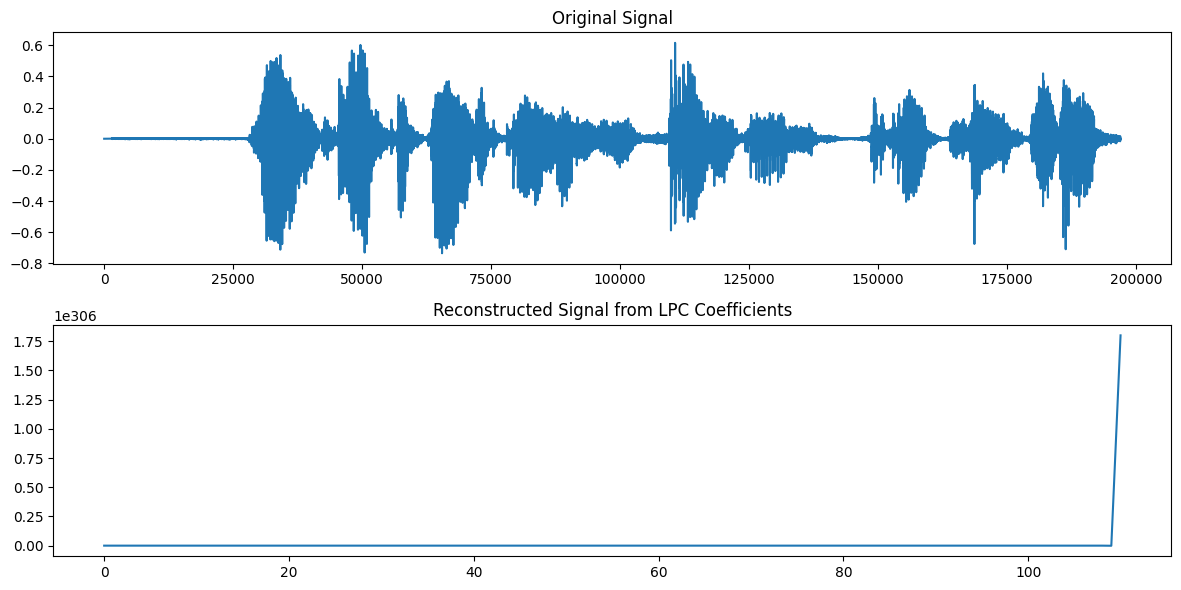

In [100]:
plt.figure(figsize=(12, 6))
# Plot original signal
plt.subplot(2, 1, 1)
plt.title('Original Signal')
plt.plot(signal)

# Plot reconstructed signal
plt.subplot(2, 1, 2)
plt.title('Reconstructed Signal from LPC Coefficients')
plt.plot(reconstructed_signal)

plt.tight_layout()
plt.show()

Estimate Formants from LPC Coefficients

In [101]:
def estimate_formants(lpc_coeffs):
    roots = np.roots(lpc_coeffs)
    # Keep only the roots in the upper half of the unit circle
    formants = np.angle(roots[roots.imag >= 0])
    # Convert to frequencies in Hz
    formant_freqs = np.sort(np.abs(formants) * (sr / (2 * np.pi)))
    # Filter out unrealistic high frequencies
    formant_freqs = formant_freqs[formant_freqs < 4000]  # Keep only frequencies below 4000 Hz
    return formant_freqs[:2]  # Return the first two formants

In [102]:
# Known formant frequencies for vowels
known_formants = {
    'a': [730, 1090],
    'e': [660, 1700],
    'i': [440, 3000],
}

def compare_formants(estimated_formants, known_formants):
    matches = {}
    for vowel, freqs in known_formants.items():
        f1_diff = abs(freqs[0] - estimated_formants[0])
        f2_diff = abs(freqs[1] - estimated_formants[1])

        # Store the differences
        matches[vowel] = (f1_diff, f2_diff)

    # Find the vowel with the smallest combined difference
    best_match = min(matches, key=lambda k: matches[k][0] + matches[k][1])
    return best_match, matches[best_match]

# Estimate formants from LPC coefficients
estimated_formants = estimate_formants(lpc_coeffs)

# Compare estimated formants with known values
best_vowel_match, differences = compare_formants(estimated_formants, known_formants)

print(f"Estimated Formants: {estimated_formants}")
print(f"Best Vowel Match: {best_vowel_match}")
print(f"Differences (F1, F2): {differences}")

Estimated Formants: [0. 0.]
Best Vowel Match: a
Differences (F1, F2): (730.0, 1090.0)


Plot the Formant Frequencies

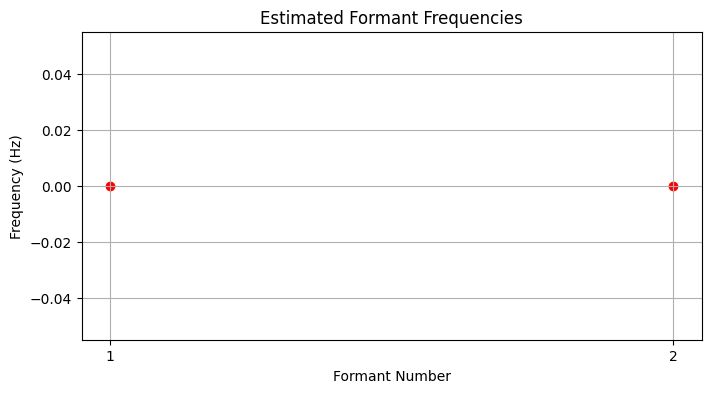

In [103]:
plt.figure(figsize=(8, 4))
plt.title('Estimated Formant Frequencies')
plt.xlabel('Formant Number')
plt.ylabel('Frequency (Hz)')
plt.scatter(range(1, len(estimated_formants) + 1), estimated_formants, color='red')
plt.xticks(range(1, len(estimated_formants) + 1))
plt.grid()
plt.show()

Visualize the Formants on a Frequency Response Plot

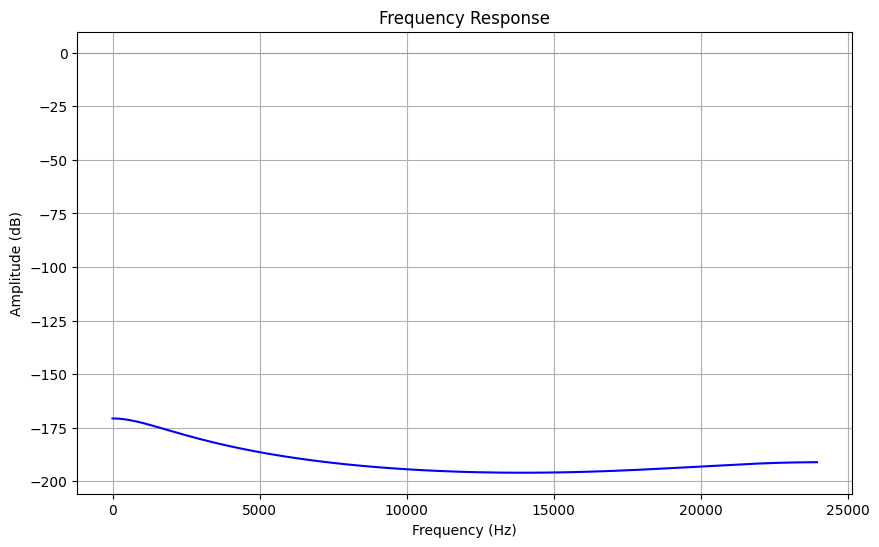

In [104]:
from scipy.signal import freqz

w, h = freqz([1], lpc_coeffs)

plt.figure(figsize=(10, 6))
plt.plot(w / np.pi * (sr / 2), 20 * np.log10(abs(h)), 'b')
plt.title('Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.grid()
plt.axhline(0, color='gray', linewidth=0.5, linestyle='--')
plt.show()